<a href="https://colab.research.google.com/github/gunelaliyevaa/wildfire-detection-using-satellite-imagery/blob/main/classification_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Splitter

In [ ]:
"""split_dataset.py
===================

Utility script to split a dataset structured as::

    input_dir/
        fire/
        no_fire/

into *train*, *val* and *test* folders with the same sub‑folder layout.

The default ratios are 80 % / 10 % / 10 % but can be overridden via the
command‑line. All files are **copied** (not moved) so the original dataset
remains intact.

Examples
--------
Split with default ratios::

    python split_dataset.py --input-dir /data/images --output-dir /data/images_split

Custom split (70 % / 20 % / 10 %) and a different random seed::

    python split_dataset.py \
        --train 0.7 --val 0.2 --test 0.1 \
        --seed 123 \
        --input-dir /data/images \
        --output-dir /data/images_split
"""
from __future__ import annotations

import argparse
import os
import random
import shutil
from pathlib import Path
from typing import Iterable, Sequence

# ---------------------------------------------------------------------------
# Core logic
# ---------------------------------------------------------------------------

CLASS_NAMES: Sequence[str] = ("fire", "no_fire")


def split_dataset(
    *,
    input_dir: Path,
    output_dir: Path,
    train_ratio: float = 0.8,
    val_ratio: float = 0.1,
    test_ratio: float = 0.1,
    seed: int = 42,
) -> None:
    """Split *input_dir* into *train* / *val* / *test* folders.

    Args:
        input_dir: Directory with sub‑folders named after ``CLASS_NAMES``.
        output_dir: Destination root; will be created if missing.
        train_ratio: Fraction of images for the training split.
        val_ratio: Fraction for validation.
        test_ratio: Fraction for testing.
        seed: Random seed for reproducibility.

    Raises:
        ValueError: If the split ratios do not sum to 1.0 (±1e‑6).
        FileNotFoundError: If *input_dir* or required class sub‑folders are
            missing.
    """
    # --- Validate ratios ---
    if not abs((train_ratio + val_ratio + test_ratio) - 1.0) < 1e-6:
        raise ValueError("train + val + test ratios must sum to 1.0")

    # --- Validate folders ---
    if not input_dir.is_dir():
        raise FileNotFoundError(f"Input directory not found: {input_dir}")
    for cls in CLASS_NAMES:
        if not (input_dir / cls).is_dir():
            raise FileNotFoundError(f"Missing class folder: {input_dir / cls}")

    # --- Create output sub‑folders (idempotent) ---
    for split in ("train", "val", "test"):
        for cls in CLASS_NAMES:
            (output_dir / split / cls).mkdir(parents=True, exist_ok=True)

    # --- Split & copy ---
    random.seed(seed)
    for cls in CLASS_NAMES:
        class_path = input_dir / cls
        images = [f for f in class_path.iterdir() if f.is_file()]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        splits: dict[str, Iterable[Path]] = {
            "train": images[:n_train],
            "val": images[n_train : n_train + n_val],
            "test": images[n_train + n_val :],
        }

        for split_name, file_list in splits.items():
            target_dir = output_dir / split_name / cls
            for src_path in file_list:
                dst_path = target_dir / src_path.name
                shutil.copy2(src_path, dst_path)

    print("Dataset has been split and copied successfully!")


# ---------------------------------------------------------------------------
# CLI interface
# ---------------------------------------------------------------------------

def parse_args() -> argparse.Namespace:  # noqa: D401
    """Parse command‑line arguments."""
    parser = argparse.ArgumentParser(description="Split Fire/No‑Fire dataset.")
    parser.add_argument("--input-dir", type=Path, required=True, help="Input dataset directory (with class sub‑folders)")
    parser.add_argument("--output-dir", type=Path, required=True, help="Output root directory for the split dataset")
    parser.add_argument("--train", type=float, default=0.8, dest="train_ratio", help="Train split ratio (default: 0.8)")
    parser.add_argument("--val", type=float, default=0.1, dest="val_ratio", help="Validation split ratio (default: 0.1)")
    parser.add_argument("--test", type=float, default=0.1, dest="test_ratio", help="Test split ratio (default: 0.1)")
    parser.add_argument("--seed", type=int, default=42, help="Random seed (default: 42)")
    return parser.parse_args()


if __name__ == "__main__":
    args = parse_args()
    split_dataset(
        input_dir=args.input_dir,
        output_dir=args.output_dir,
        train_ratio=args.train_ratio,
        val_ratio=args.val_ratio,
        test_ratio=args.test_ratio,
        seed=args.seed,
    )
"}


In [ ]:
# ------------------------
# Data paths / class namesauto split
# ------------------------
#dataset_path = "/content/drive/MyDrive/patched_images"
#fire_class, no_fire_class = "fire", "no_fire"
#class_names = {0: "No Fire", 1: "Fire"}

#fire_images    = [os.path.join(dataset_path, fire_class, f)     for f in os.listdir(os.path.join(dataset_path, fire_class))]
#no_fire_images = [os.path.join(dataset_path, no_fire_class, f)  for f in os.listdir(os.path.join(dataset_path, no_fire_class))]

#all_images  = fire_images + no_fire_images
#all_labels  = [1]*len(fire_images) + [0]*len(no_fire_images)  # 1 = Fire, 0 = No Fire

# ---------------
# Train/val/test split 80 / 10 / 10 or 75 / 10 / 10
# ---------------
#train_imgs, tmp_imgs, train_labs, tmp_labs = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
#val_imgs,  test_imgs, val_labs,  test_labs  = train_test_split(tmp_imgs, tmp_labs, test_size=0.5, stratify=tmp_labs,  random_state=42)

#print(f"Dataset Split: Train={len(train_imgs)}, Validation={len(val_imgs)}, Test={len(test_imgs)}")


#Training Pipeline

In [ ]:
"""Classifier
================================

A reproducible **Fire / No‑Fire image classifier** built with PyTorch.
The script covers the full workflow:

1. Data loading and on‑the‑fly augmentation.
2. Transfer‑learning with *EfficientNet‑B0* (configurable).
3. Early‑stopping‑aware training loop.
4. Helper utilities for evaluation and visualisation.

To keep the example concise yet production‑ready, the model is trained on
an assumed directory layout:

```
patched_images_split/
 ├── train/
 │   ├── fire/
 │   └── no_fire/
 ├── val/
 │   ├── fire/
 │   └── no_fire/
 └── test/
     ├── fire/
     └── no_fire/
```

Adjust *``base_split_path``* as needed.

Run the script directly to start training::

    python fire_no_fire_classifier.py

"""
from __future__ import annotations

# Standard library imports
import os
import random
import time
from tempfile import TemporaryDirectory
from typing import Literal

# Third‑party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F  # noqa: F401 – imported for potential custom heads
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from albumentations import Compose as ACompose
from albumentations import Normalize as ANormalize
from albumentations import Resize as AResize
from albumentations import CenterCrop as ACenterCrop
from albumentations.pytorch import ToTensorV2
from sklearn.calibration import calibration_curve
from sklearn.metrics import (classification_report, f1_score, precision_score,
                             recall_score)
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from PIL import Image
from tqdm import tqdm  # noqa: F401 – kept for optional progress bars

# ---------------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------------

#: Root directory containing ``train/``, ``val/`` and ``test/`` splits.
BASE_SPLIT_PATH: str = "/content/drive/MyDrive/patched_images_split"

#: Sub‑directory names per class.
FIRE_CLASS: str = "fire"
NO_FIRE_CLASS: str = "no_fire"

#: Human‑readable names per class index (0 = no‑fire, 1 = fire).
CLASS_NAMES: dict[int, str] = {0: "No Fire", 1: "Fire"}

#: Batch size used for all loaders.
BATCH_SIZE: int = 32

#: Device used for training / inference (GPU if available).
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------------------------
# Dataset helpers
# ---------------------------------------------------------------------------

def get_image_paths_labels(split: Literal["train", "val", "test"]):
    """Return image paths *and* integer labels for the given *split*."""
    fire_path = os.path.join(BASE_SPLIT_PATH, split, FIRE_CLASS)
    no_fire_path = os.path.join(BASE_SPLIT_PATH, split, NO_FIRE_CLASS)

    fire_images = [
        os.path.join(fire_path, f)
        for f in os.listdir(fire_path)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]
    no_fire_images = [
        os.path.join(no_fire_path, f)
        for f in os.listdir(no_fire_path)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    images = fire_images + no_fire_images
    labels = [1] * len(fire_images) + [0] * len(no_fire_images)
    return images, labels


class FireDataset(Dataset):
    """Custom PyTorch *Dataset* for Fire / No‑Fire images.

    Args:
        image_paths: List of absolute image paths.
        labels: Parallel list of integer labels (0 or 1).
        transform: Either a *torchvision* ``transforms.Compose`` or an
            *Albumentations* pipeline. ``None`` disables augmentation.
    """

    def __init__(self, image_paths: list[str], labels: list[int], transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:  # noqa: D401 – simple return
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        # Load with OpenCV (BGR → RGB)
        img = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        # Apply transforms
        if self.transform:
            if isinstance(self.transform, transforms.Compose):
                img = Image.fromarray(img)
                img = self.transform(img)
            else:  # Albumentations pipeline
                img = self.transform(image=img)["image"]

        return img, torch.tensor(label, dtype=torch.long)


# ---------------------------------------------------------------------------
# Transforms (torchvision for train/val, Albumentations for test)
# ---------------------------------------------------------------------------

data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
            transforms.RandomApply(
                [
                    transforms.ColorJitter(0.3, 0.3, 0.3),
                    transforms.RandomAffine(
                        degrees=15, translate=(0.05, 0.05), scale=(0.95, 1.05)
                    ),
                ],
                p=0.5,
            ),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": ACompose(
        [
            AResize(224, 224),
            ACenterCrop(224, 224),
            ANormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    ),
}

# ---------------------------------------------------------------------------
# Data loaders
# ---------------------------------------------------------------------------

train_imgs, train_labs = get_image_paths_labels("train")
val_imgs, val_labs = get_image_paths_labels("val")
test_imgs, test_labs = get_image_paths_labels("test")

print(
    f"Dataset Loaded: Train={len(train_imgs)}, Validation={len(val_imgs)}, Test={len(test_imgs)}"
)

train_ds = FireDataset(train_imgs, train_labs, data_transforms["train"])
val_ds = FireDataset(val_imgs, val_labs, data_transforms["val"])
test_ds = FireDataset(test_imgs, test_labs, data_transforms["test"])

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False, num_workers=2)

print(
    f"Train Loader: {len(train_loader)} batches | Val Loader: {len(val_loader)} | Test Loader: {len(test_loader)}"
)

# ---------------------------------------------------------------------------
# Model definition
# ---------------------------------------------------------------------------

model_conv = torchvision.models.efficientnet_b0(
    weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
)

# Freeze backbone – train *only* the classifier head
for name, param in model_conv.named_parameters():
    param.requires_grad = "classifier" in name

num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, 2)

#ResNet18
#num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 2)

#for name, param in model_conv.named_parameters():
#    param.requires_grad = ("fc" in name)

# DenseNet121
#for name, param in model_conv.named_parameters():
#    param.requires_grad = ("classifier" in name)

#num_ftrs = model_conv.classifier.in_features
#model_conv.classifier = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(DEVICE)

# Loss, optimiser & scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=1e-4)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Convenience dicts for training loop
dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_ds), "val": len(val_ds)}

# ---------------------------------------------------------------------------
# Training with early stopping
# ---------------------------------------------------------------------------

def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler: optim.lr_scheduler._LRScheduler,
    *,
    num_epochs: int = 25,
    early_stopping_patience: int = 5,
    early_stopping_delta: float = 0.001,
    monitor: Literal["val_loss", "val_acc"] = "val_loss",
):
    """Train *model* with optional early stopping.

    Args:
        model: The neural network to train.
        criterion: Differentiable loss function.
        optimizer: Param optimiser (e.g. AdamW).
        scheduler: LR scheduler (stepped each *train* epoch).
        num_epochs: Maximum epochs to train for.
        early_stopping_patience: Stop after *patience* epochs without
            improvement.
        early_stopping_delta: Minimum *change* considered an improvement.
        monitor: Metric to monitor – ``"val_loss"`` (lower = better) or
            ``"val_acc"`` (higher = better).

    Returns:
        (best_model, metrics_dict)
    """
    since = time.time()
    metrics: dict[str, list[float]] = {k: [] for k in ("train_loss", "val_loss", "train_acc", "val_acc")}

    # --- Track best weights on disk (robust to OOM) ---
    with TemporaryDirectory() as tempdir:
        best_path = os.path.join(tempdir, "best.pt")
        torch.save(model.state_dict(), best_path)

        best_metric_value = float("inf") if monitor == "val_loss" else -float("inf")
        patience_counter = 0

        print(f"{'Epoch':^8}|{'TrainLoss':^12}|{'TrainAcc':^10}|{'ValLoss':^10}|{'ValAcc':^10}")
        print("-" * 60)

        for epoch in range(1, num_epochs + 1):
            epoch_stats: dict[str, tuple[float, float]] = {}

            # ----------------- Train *and* validate -----------------
            for phase in ("train", "val"):
                model.train() if phase == "train" else model.eval()
                running_loss, running_corrects = 0.0, 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels)

                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                metrics[f"{phase}_loss"].append(epoch_loss)
                metrics[f"{phase}_acc"].append(epoch_acc.item())
                epoch_stats[phase] = (epoch_loss, epoch_acc)

            tl, ta = epoch_stats["train"]
            vl, va = epoch_stats["val"]
            print(f"{epoch:^8}|{tl:^12.4f}|{ta:^10.4f}|{vl:^10.4f}|{va:^10.4f}")

            # ----------------- Early stopping -----------------
            current = vl if monitor == "val_loss" else va
            improved = (
                (current < best_metric_value - early_stopping_delta)
                if monitor == "val_loss"
                else (current > best_metric_value + early_stopping_delta)
            )

            if improved:
                best_metric_value = current
                patience_counter = 0
                torch.save(model.state_dict(), best_path)
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(
                        f"\nEarly stopping triggered after {epoch} epochs "
                        f"(no improvement in {early_stopping_patience} checks)."
                    )
                    break

        # --- Training summary ---
        time_elapsed = time.time() - since
        mins, secs = divmod(time_elapsed, 60)
        print(f"\nTraining complete in {mins:.0f}m {secs:.0f}s")
        print(f"Best {monitor}: {best_metric_value:.4f}")

        model.load_state_dict(torch.load(best_path))
        torch.save(model.state_dict(), "final_model_params.pt")
        return model, metrics


# ---------------------------------------------------------------------------
# Visualisation helpers
# ---------------------------------------------------------------------------

def plot_metrics(metrics: dict[str, list[float]]):  # noqa: D401 – simple wrapper
    """Plot loss & accuracy curves on a two‑panel figure."""
    epochs = range(1, len(metrics["train_loss"]) + 1)
    plt.figure(figsize=(14, 4))

    # --- Loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], "o-", label="Train")
    plt.plot(epochs, metrics["val_loss"], "o-", label="Val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_acc"], "o-", label="Train")
    plt.plot(epochs, metrics["val_acc"], "o-", label="Val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


def visualize_model(model: nn.Module, num_images: int = 15):
    """Show **val** images with predicted vs. true labels."""
    model.eval()
    cols = 5
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    val_indices = list(range(len(val_loader.dataset)))
    random.shuffle(val_indices)

    with torch.no_grad():
        for ax_idx, idx in enumerate(val_indices[:num_images]):
            img, label = val_loader.dataset[idx]
            output = model(img.unsqueeze(0).to(DEVICE))
            _, pred = torch.max(output, 1)

            img_disp = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_disp = np.clip(std * img_disp + mean, 0, 1)

            axes[ax_idx].imshow(img_disp)
            axes[ax_idx].axis("off")
            color = "green" if pred.item() == label else "red"
            axes[ax_idx].set_title(
                f"Pred: {CLASS_NAMES[pred.item()]}\nTrue: {CLASS_NAMES[label.item()]}",
                color=color,
                fontsize=10,
            )

    # Hide empty subplots
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def evaluate_precision_recall_f1(model: nn.Module, dataloader: DataLoader):
    """Print and return *precision*, *recall* & *F1* on *dataloader*."""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision = precision_score(all_labels, all_preds, average="binary")
    recall = recall_score(all_labels, all_preds, average="binary")
    f1 = f1_score(all_labels, all_preds, average="binary")

    print(f"\nPrecision: {precision:.2f}")
    print(f"Recall:    {recall:.2f}")
    print(f"F1 Score:  {f1:.2f}")
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=["No Fire", "Fire"]))

    return precision, recall, f1


def collect_probs_labels(model: nn.Module, dataloader: DataLoader):
    """Collect predicted *probabilities* (of class *Fire*) & ground truths."""
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # ‹Fire› probability
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_probs), np.concatenate(all_labels)


def plot_calibration_curve(probs: np.ndarray, labels: np.ndarray, *, n_bins: int = 10):
    """Plot a reliability curve showing calibration quality."""
    prob_true, prob_pred = calibration_curve(labels, probs, n_bins=n_bins)

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker="o", label="Model Calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Reliability (Calibration) Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ---------------------------------------------------------------------------
# Entrypoint
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    model_conv, history = train_model(
        model_conv,
        criterion,
        optimizer,
        scheduler,
        num_epochs=50,  # Max epochs
        early_stopping_patience=5,
        early_stopping_delta=0.001,
        monitor="val_loss",  # Or "val_acc"
    )

    # Example post‑training usage:
    # plot_metrics(history)
    # visualize_model(model_conv)
    # precision, recall, f1 = evaluate_precision_recall_f1(model_conv, test_loader)
"}


Dataset Loaded: Train=576, Validation=72, Test=72
Train Loader: 18 batches | Val Loader: 3 | Test Loader: 3


Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 49.0MB/s]


 Epoch  | TrainLoss  | TrainAcc | ValLoss  |  ValAcc  
------------------------------------------------------------
   1    |   0.7068   |  0.5069  |  0.6878  |  0.5694  
   2    |   0.6886   |  0.5260  |  0.6693  |  0.6111  
   3    |   0.6696   |  0.6094  |  0.6545  |  0.6944  
   4    |   0.6592   |  0.6285  |  0.6530  |  0.6667  
   5    |   0.6443   |  0.6840  |  0.6338  |  0.7222  
   6    |   0.6430   |  0.6476  |  0.6320  |  0.7361  
   7    |   0.6370   |  0.6719  |  0.6302  |  0.7361  
   8    |   0.6371   |  0.6840  |  0.6251  |  0.7500  
   9    |   0.6246   |  0.7014  |  0.6224  |  0.7778  
   10   |   0.6353   |  0.6892  |  0.6237  |  0.7500  
   11   |   0.6152   |  0.7170  |  0.6123  |  0.7361  
   12   |   0.6190   |  0.7188  |  0.6056  |  0.7778  
   13   |   0.6125   |  0.7135  |  0.5964  |  0.7778  
   14   |   0.5924   |  0.7413  |  0.5933  |  0.7778  
   15   |   0.5937   |  0.7431  |  0.5780  |  0.7917  
   16   |   0.5805   |  0.7552  |  0.5772  |  0.7917  
   1

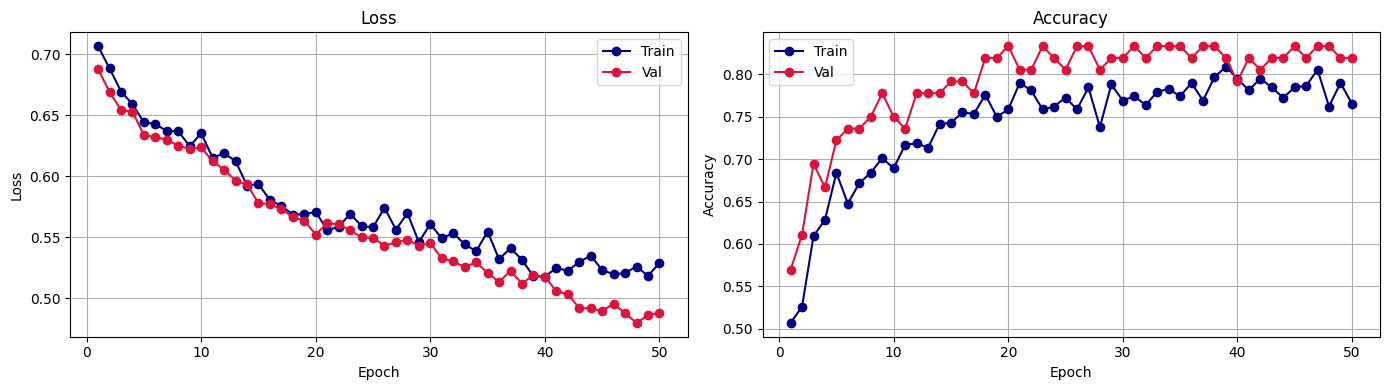

In [ ]:
plot_metrics(history)

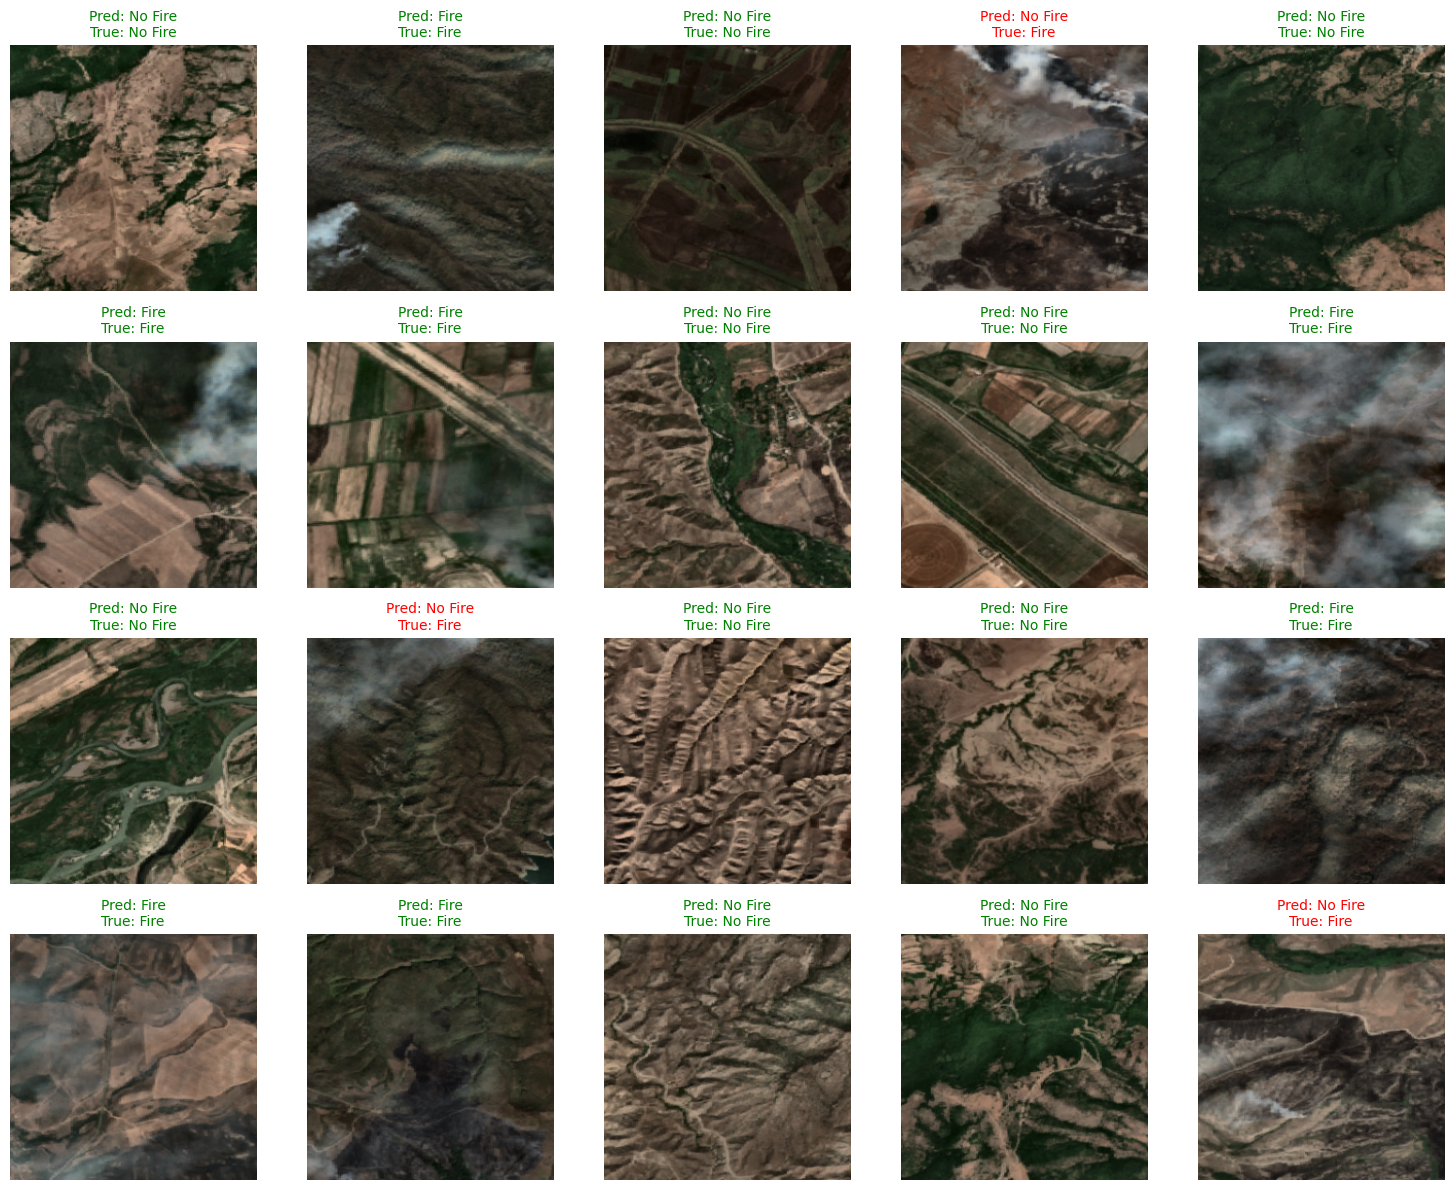

In [ ]:
visualize_model(model_conv, num_images=20)

In [ ]:
evaluate_precision_recall_f1(model_conv, test_loader, device)


Precision: 0.89
Recall:    0.69
F1 Score:  0.78

Classification Report:

              precision    recall  f1-score   support

     No Fire       0.75      0.92      0.82        36
        Fire       0.89      0.69      0.78        36

    accuracy                           0.81        72
   macro avg       0.82      0.81      0.80        72
weighted avg       0.82      0.81      0.80        72



(0.8928571428571429, 0.6944444444444444, 0.78125)